# Solar bias comparison

I have some initial results from the solar forcing test! For context: I put sensors on the roof of the UW Atmos building for about a week to get some information about the effectiveness of shielding options and to compare light sensor data between sensors and against the UW radiometer. I haven't done the comparison with UW data yet, but I have made some plots comparing the sensors. Unfortunately I did not have time to get the iButtons into this experiment, so I only put out the new vs. old hobo pendants. The sensors were mounted on bamboo poles, which were spray-painted white. The poles had the following configurations:

1. Multi-sensor pole of new pendants
    - 3 sensors total: one on top pointing up, two on the sides pointing out (parallel to pole). All unshielded.
2. Multi-sensor pole of old pendants
    - Same configuration
3. New pendant, on top pointing up, unshielded
4. New pendant, shielded with HVAC tape
5. New pendant, shielded with PVC (not fully enclosed, but pvc cap covering the top of the sensor body, secured with white electrical tape) 
6. New pendant, shielded with mylar
7. Old pendant, on top pointing up, unshielded
8. Old pendant, shielded with HVAC tape (except for the very top, so the mounting hole remained exposed)


The test occurred from May 28th to June 5th. That period included a nice variety of weather: full sun, partial cloud, full cloud, and rain accompanied by a high-wind event (June 4th). Photos of the deployment are included in this folder.

The following also serves as an example of how to use the `jiflr` package to read pendant data and to quickly visualize it.

In [2]:
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sci

from jiflr.data import read_hobo_pendants, clean_hobo_pendants

plt.style.use("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
dir_path = Path("data/experiments/2024/solar_bias_comparison/data/raw")
ps = list(dir_path.glob('*.csv'))
clean_hobo_pendants(ps, dir_path.parent)

In [4]:
ps = list(Path('data/').glob('*.nc'))  # find all files with .nc extension in this folder
ps

[PosixPath('data/21714618_20240528T1202_20240605T1743.nc'),
 PosixPath('data/22008797_20240528T1311_20240605T1758.nc'),
 PosixPath('data/22008799_20240528T1314_20240605T1806.nc'),
 PosixPath('data/21716170_20240528T1211_20240605T1747.nc'),
 PosixPath('data/21714745_20240528T1222_20240605T1741.nc'),
 PosixPath('data/21716169_20240528T1201_20240605T1743.nc'),
 PosixPath('data/21715628_20240528T1200_20240605T1745.nc'),
 PosixPath('data/21716171_20240528T1222_20240605T1742.nc'),
 PosixPath('data/22008794_20240528T1312_20240605T1807.nc'),
 PosixPath('data/22008798_20240528T1314_20240605T1758.nc'),
 PosixPath('data/21714743_20240528T1156_20240605T1746.nc')]

The data is read in as a `xarray` dataset. This format provides a great range of flexibility for the future. For small datasets such as this, however, it can easily be converted to a `pandas` object with `ds.to_pandas()`.

In [5]:
ds = read_hobo_pendants(ps)  # read in data as an xarray dataset
ds

100%|██████████| 11/11 [00:00<00:00, 18.78it/s]


<xarray.Dataset> Size: 2MB
Dimensions:        (sensor_id: 11, datetime: 11892)
Coordinates:
  * datetime       (datetime) datetime64[ns] 95kB 2024-05-28T11:56:00 ... 202...
  * sensor_id      (sensor_id) object 88B '21714618' '22008797' ... '21714743'
Data variables:
    intensity_lux  (sensor_id, datetime) float64 1MB nan nan nan ... nan nan nan
    temp_c         (sensor_id, datetime) float64 1MB nan nan nan ... nan nan nan

In [6]:
# This is an ad-hoc deployment log! Please see the manual and other examples for how to do this with icefield data.
id_map = pd.read_csv(Path('sensor_ids.csv')).set_index('sensor_id')
id_map

,sensor_generation,exp
sensor_id,,
21716169,new,top of pole
21716171,new,side of pole
21714745,new,side of pole
21714618,new,top of pole
22008798,old,side of pole
22008794,old,top of pole
22008797,old,side of pole
22008799,old,hvac
21715628,new,hvac


In [7]:
# Convert to pandas, clean and convert to "tidy" data for easy plotting with seaborn.
# Merge with metadata, and finally create a version of the dataset resampled from 1min intervals to 15min intervals,
# which will make life easier for some purposes, and can be a good first step for large datasets. When doing this, be
# sure your interpretation of the resampled data is consistent with that of the full dataset. 
df = ds['temp_c'].to_pandas().T
df = df.reset_index()
df = df.melt(id_vars='datetime', var_name="sensor_id", value_name="temp_c")  # make tidy
df['sensor_id'] = pd.to_numeric(df['sensor_id'])
df = df.merge(id_map, left_on='sensor_id', right_index=True, how='left')

In [8]:
# find the earliest and latest time where all sensors were deployed
head = df.sort_values(by='datetime').dropna().groupby('sensor_id').head(1)
tail = df.sort_values(by='datetime').dropna().groupby('sensor_id').tail(1)
pd.concat([head, tail])

dt_start = datetime(2024, 5, 28, 13, 15)
dt_end = datetime(2024, 6, 5, 17, 42)
dt_mask = (df.datetime > dt_start) & (df.datetime < dt_end)
df = df[dt_mask]

df.groupby('sensor_id')['datetime'].count()

sensor_id
21714618    11786
21714743    11786
21714745    11786
21715628    11786
21716169    11786
21716170    11786
21716171    11786
22008794    11786
22008797    11786
22008798    11786
22008799    11786
Name: datetime, dtype: int64

In [9]:
# resample while preserving metadata columns
df_15min = df.groupby([pd.Grouper(freq='15min', key='datetime'), 'exp','sensor_generation', 'sensor_id']).mean().reset_index()

# Visualizations
Here we compare the different shielding methods using the data from the new pendants. A KDE (kernal density estimation) plot helps us see the overall shape of multiple datasets without being visually cluttered. Because each curve is normalized, a narrower range (in this case, a higher peak) means the sensor recorded less extreme temperature swings. Although this doesn't show the UW weather station data for comparison, we can safely assume that temperatures never exceeded 30 degC, and that narrower distributions likely have less solar forcing bias. This assumption is supported by each series' rank by spread: the top of the pole position had the most spread, closely followed by the side of the pole.
 
The shielded sensors had much less extreme values. They all have very similar distributions, and a closer look would be needed to distinguish features. We do expect some differences between shielding methods with increasing temperature, as each material has a different combination of specific heat capacity/albedo. By eye, my guess is that the HVAC tape might be slightly more reflective than the others, but also slightly more insulating. The lower end of the plot also gives us good information. As expected, the top-of-pole sensor has a better view of the sky, and so loses more heat to a clear sky overnight. The other sensors show very little difference between shielding method.

<Axes: xlabel='temp_c', ylabel='Density'>

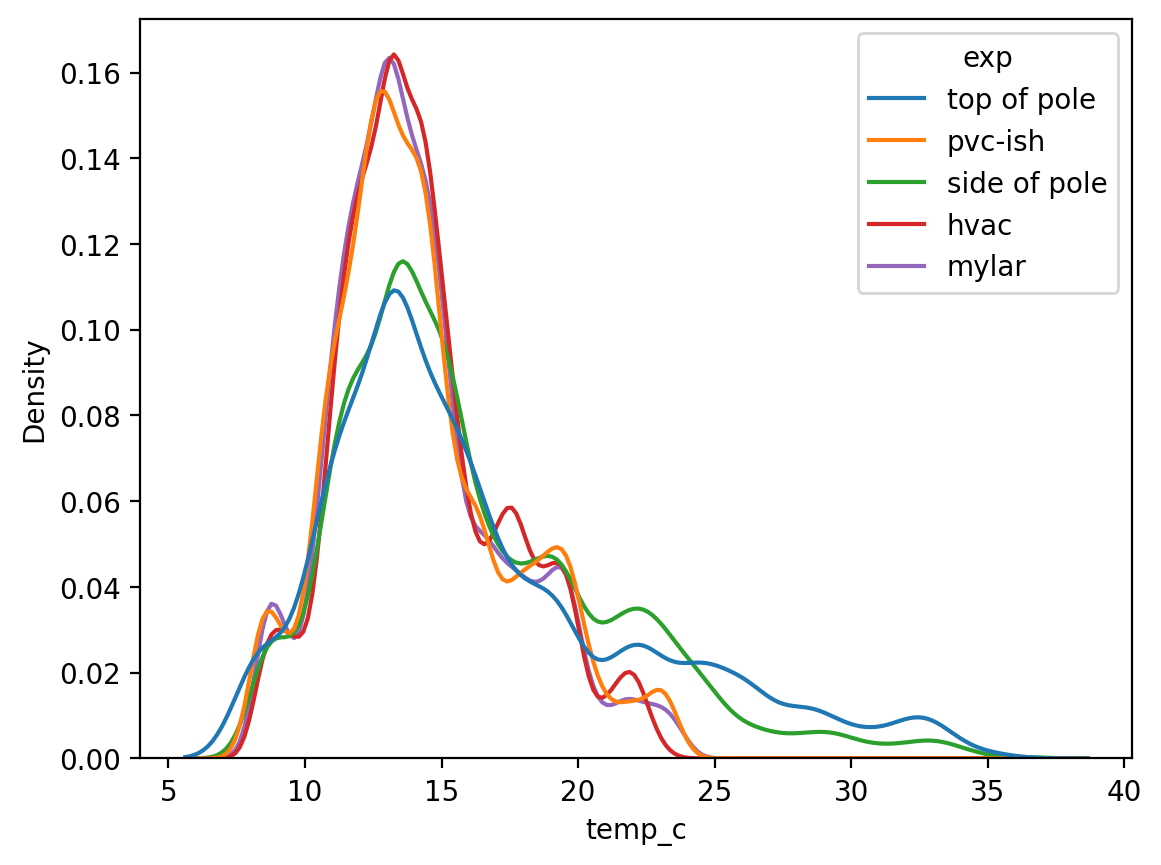

In [10]:
fig, ax = plt.subplots(dpi=200)
sns.kdeplot(x='temp_c', hue='exp', data=df.loc[df.sensor_generation == 'new'], ax=ax, legend=True, common_norm=False, common_grid=True)

Here is another view of the data, this time without the kernal density estimation potentially distorting the shape. It is consistent with the conclusions from the previous figure.

<Axes: xlabel='temp_c', ylabel='Count'>

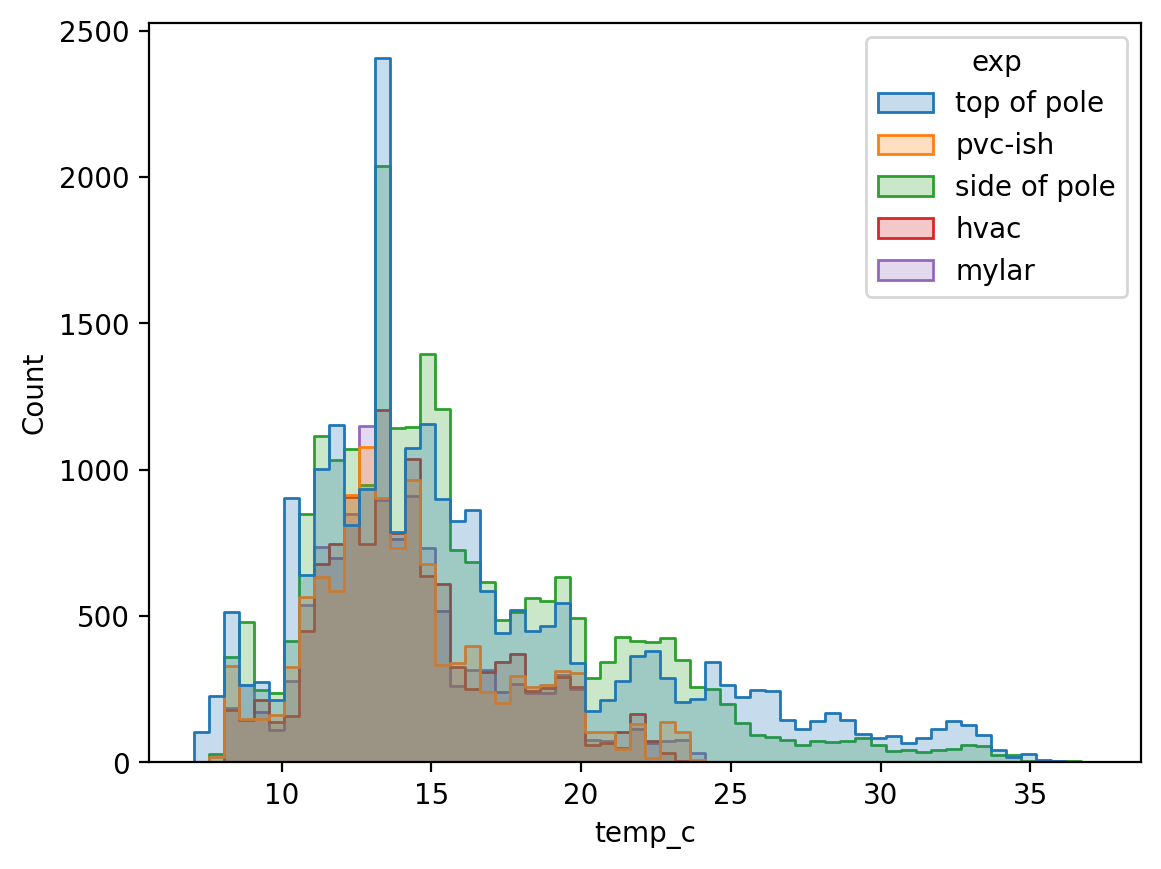

In [11]:
fig, ax = plt.subplots(dpi=200)
sns.histplot(x='temp_c', hue='exp', data=df.loc[df.sensor_generation == 'new'], ax=ax, legend=True, element='step', binwidth=0.5)

Now we leverage the convenience of seaborn to make quick comparisons between the old and new pendants. Here we show both the KDE line and the histogram on each figure. These plots suggest that, when unshielded, the old pendants are more affected by solar forcing. While some portion of the difference may come from their slightly different locations, the distribution of the old pendant temperatures are nearly identical to the new pendant temperatures when both sensors are shielded.

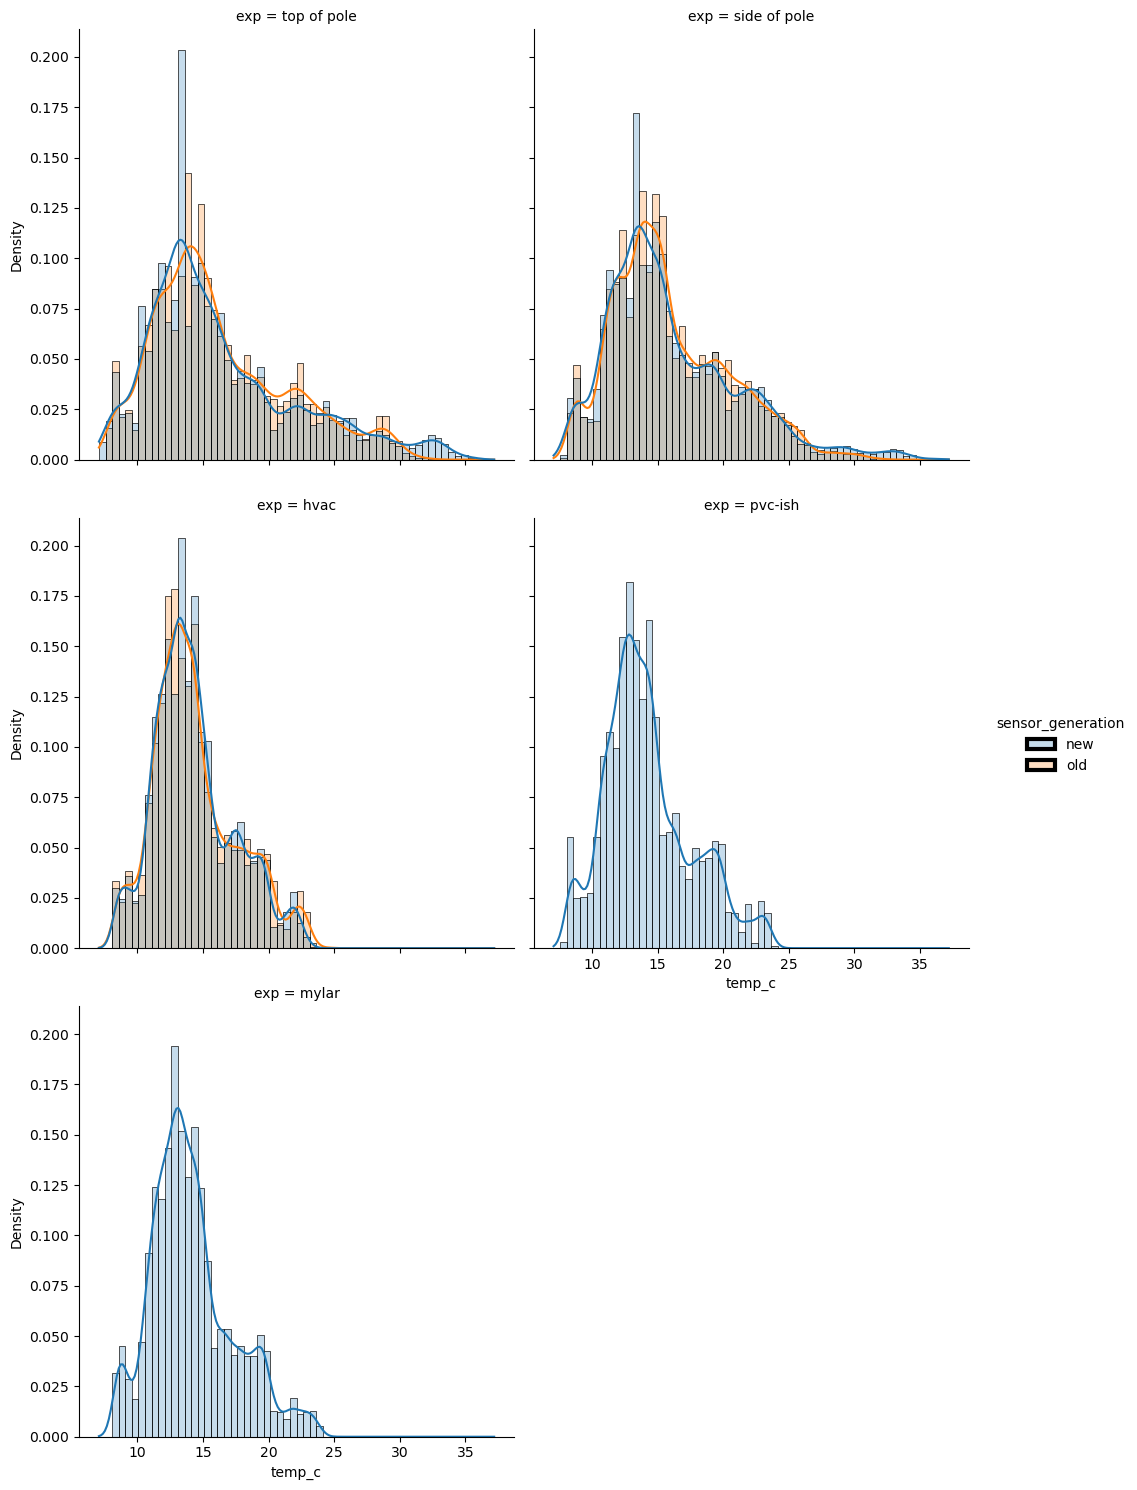

In [12]:
sns.displot(df, x='temp_c', col='exp', hue='sensor_generation', binwidth=0.5, col_wrap=2, common_bins=True, common_norm=False, kde=True, stat='density', lw=3, alpha=0.25)

Here is a side-by-side of the first comparison, but also showing data for the old sensors. Both the relative shapes of the distributions among the old pendants and their shapes in comparison to the new pendants are consistent with our prior interpretations.

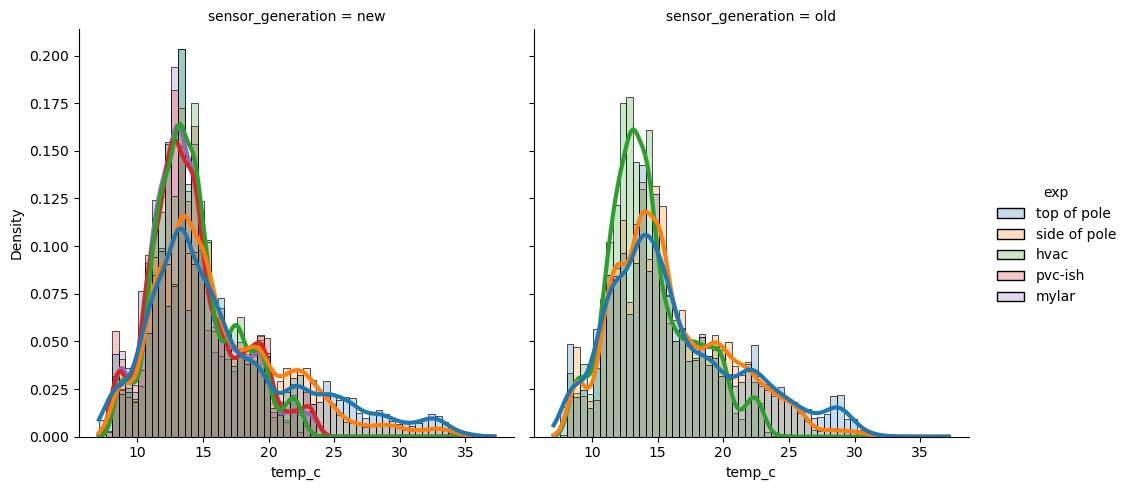

In [13]:
sns.displot(df, x='temp_c', col='sensor_generation', hue='exp', binwidth=0.5, col_wrap=2, common_bins=True, common_norm=False, kde=True, stat='density', lw=1, alpha=0.25, line_kws=dict(lw=3))

Finally (though this really should have been the first thing I did), we visualize the whole timeseries to make sure everything looks reasonable and that the relationships we observe are relatively consistent through time. For time series of this length or longer, it is also a good idea to look at 2 or 3 random days zoomed-in so individual measurements can be distinguished and evaluated. The shaded area on this plot represents the spread for categories that had more than one sensor. The line then represents the average value of those sensors. Note the ranking of series at the extremes. These tend to validate our prior assumptions. A more complete analysis would also look into the times around sunrise and sunset, as we expect to see systematic differences between shielding methods following the sudden change in solar forcing.

We can use the 15 minute data here, which plots much more quickly and tells the same story. However, it's always good to verify this by inspecting a couple random periods in the full dataset. 

<Axes: xlabel='datetime', ylabel='temp_c'>

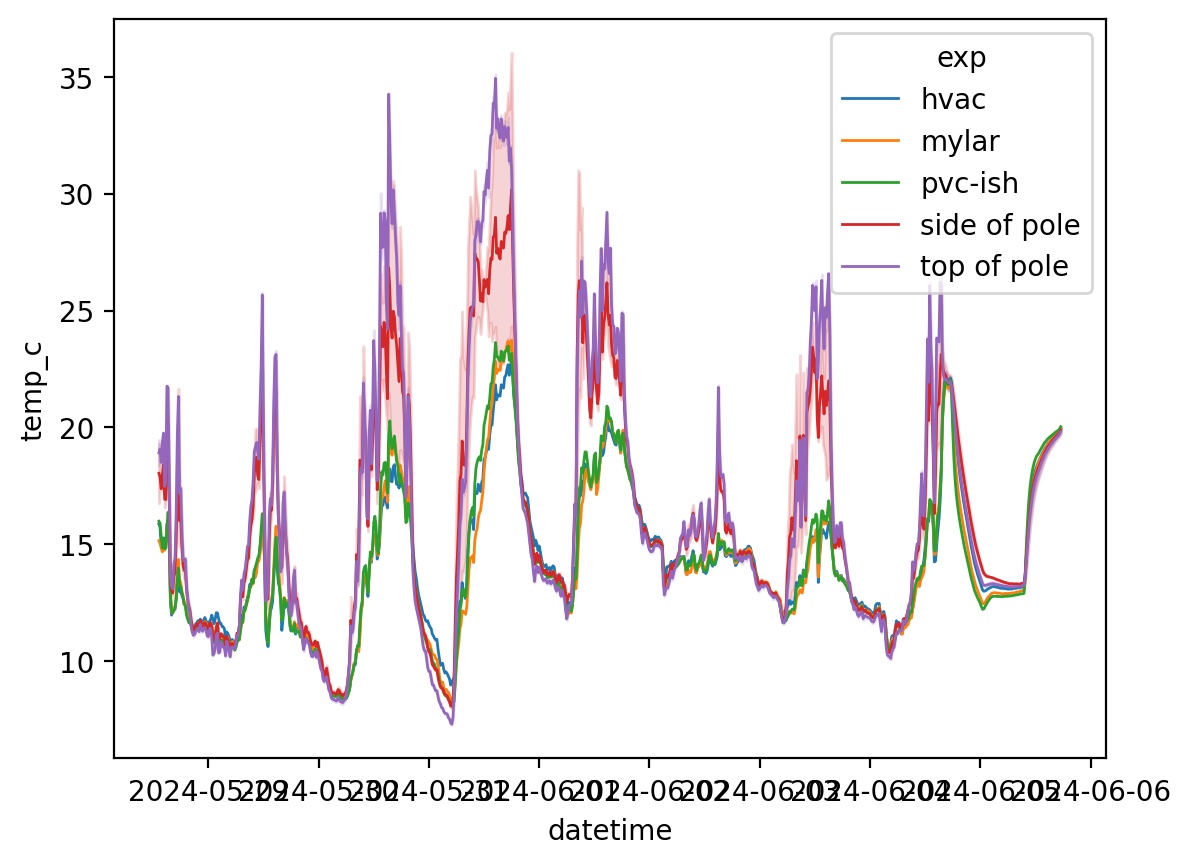

In [14]:
fig, ax = plt.subplots(dpi=200)
sns.lineplot(x='datetime', y='temp_c', hue='exp', data=df_15min.loc[df_15min.sensor_generation == 'new'], ax=ax, legend=True, lw=1)

<Axes: xlabel='datetime', ylabel='temp_c'>

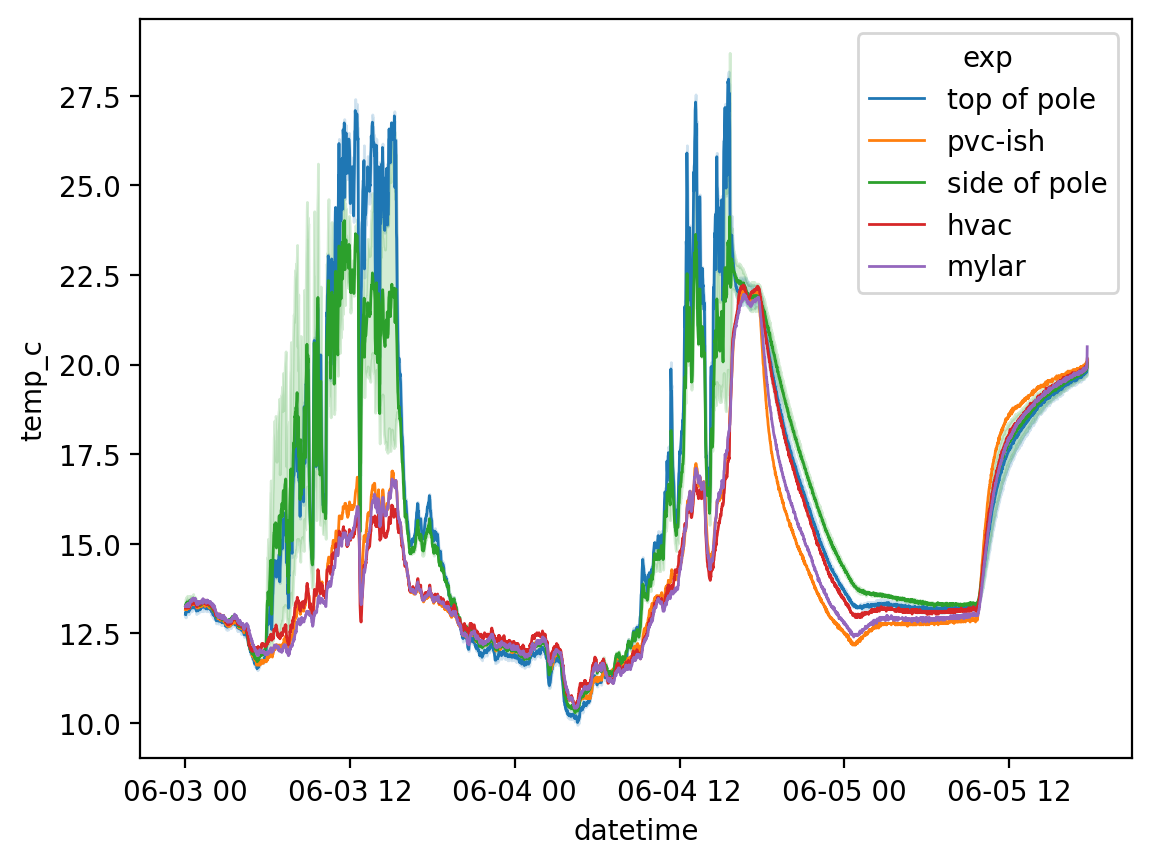

In [15]:
dt_start = datetime(2024, 6, 3, 0, 0)
dt_end = datetime(2024, 6, 6, 0, 0)
dt_mask = (df.datetime > dt_start) & (df.datetime < dt_end)
fig, ax = plt.subplots(dpi=200)
sns.lineplot(x='datetime', y='temp_c', hue='exp', data=df.loc[(df.sensor_generation == 'new') & dt_mask], ax=ax, legend=True, lw=1)

Finally, we use matplotlib's convenient spectral analysis plots to tease apart some of the differences observed above. Without getting too much into it (mostly for my sake), the following two plots show the i) power-spectral density and ii) coherence for each experiment category. Disclaimer that this is mostly for demonstration. There are additional steps needed to make this techincally correct.  

The power spectral density can be thought of as analogous to the earlier KDE plot, but describing the distribution of low-frequency noise (lower values on the x-axis) and high-frequency noise (higher values on the x-axis, where a frequency of 0.5 = a period of 2 minutes). What is important here is the *relative* power between series at a given frequency. The unshielded sensors have more low-frequency noise than the shielded ones. Of the shielded sensors, PVC appears to have the least low-frequency noise, but comparison with the weather station data is necessary before crowning it the winner.

The coherence is arbitrarily taken relative to the HVAC timeseries. In general terms, it describes whether each timeseries "agrees" with the HVAC timeseries at a given frequency. The blue line is fixed at 1, because the HVAC timeseries perfectly agrees with iteself. As we would expect, the other shielded sensors have the greatest coherence with the HVAC timeseries, and at low frequencies, all timeseries tend to agree. The greatest differences between the shielded sensors occur at periods of around 2.5-10 minutes (0.4 - 0.1), where mylar has higher coherence and PVC has lower coherence. Based on the timeframe, this is likely due to differences in specific heat capacity and thermal mass between the shielding methods. Understanding those differences would require further analysis and comparison with the weather station data. 

For now, what these plots tell us is that, for sampling intervals ~15 min, the shielding method does not matter much. While the mylar and PVC are very similar around that timeframe, there is a small difference between them and the HVAC tape. If we are willing to assume that less low-frequency noise is better (faster responding sensors), then we might lean towards PVC or mylar as our shielding method of choice.

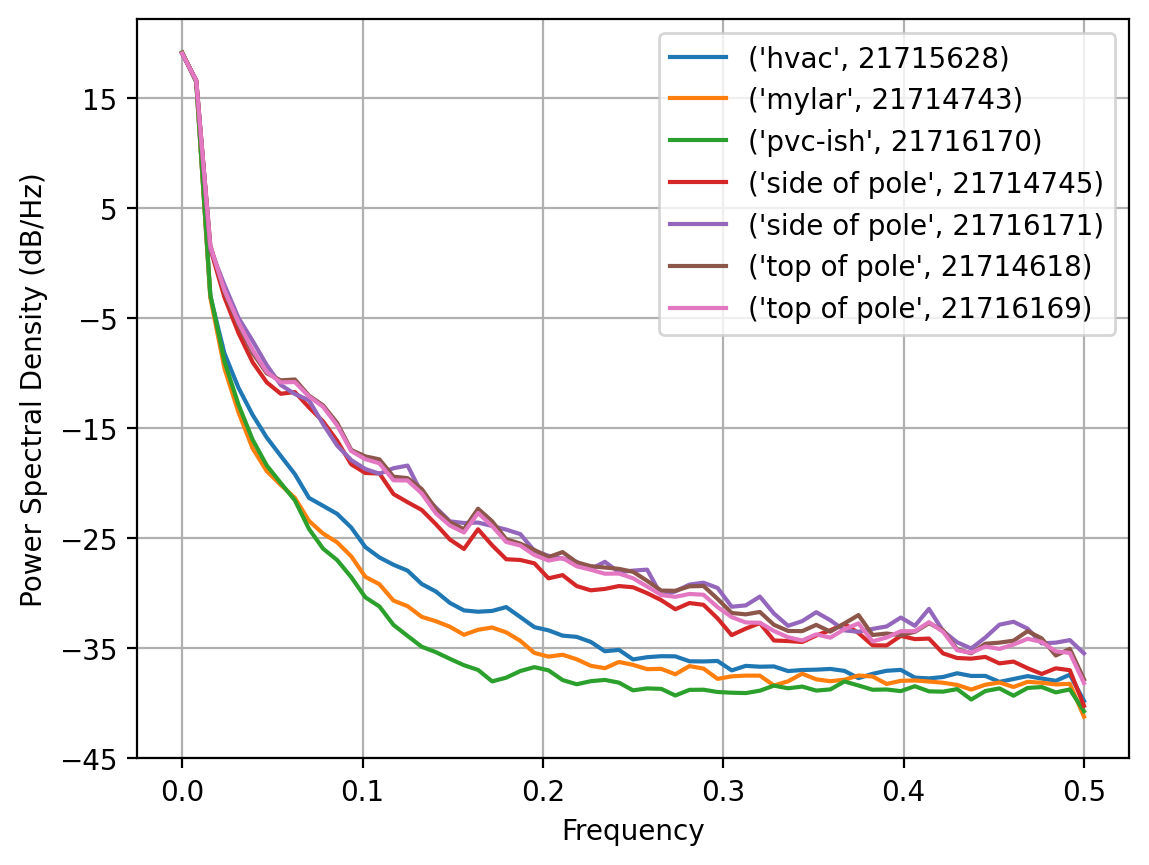

In [16]:
dfp = df.loc[df.sensor_generation == 'new']
fig, ax = plt.subplots(dpi=200)
for exp, group in dfp.groupby(['exp', 'sensor_id']):
    
    hvac = dfp.loc[(dfp.exp == 'hvac')].set_index('datetime')['temp_c']
    group = group.set_index('datetime')['temp_c']
    overlap = pd.merge(hvac, group, left_index=True, right_index=True, how='inner').dropna(how='any')
    temp = overlap.iloc[:, 1]
    temp = (temp - temp.mean())/temp.std()
    #temp = (temp - temp.mean())/temp.std()
    chunk_size = 128
    ax.psd(temp, Fs=1, NFFT=chunk_size, noverlap=chunk_size//2, label=exp)
ax.legend()

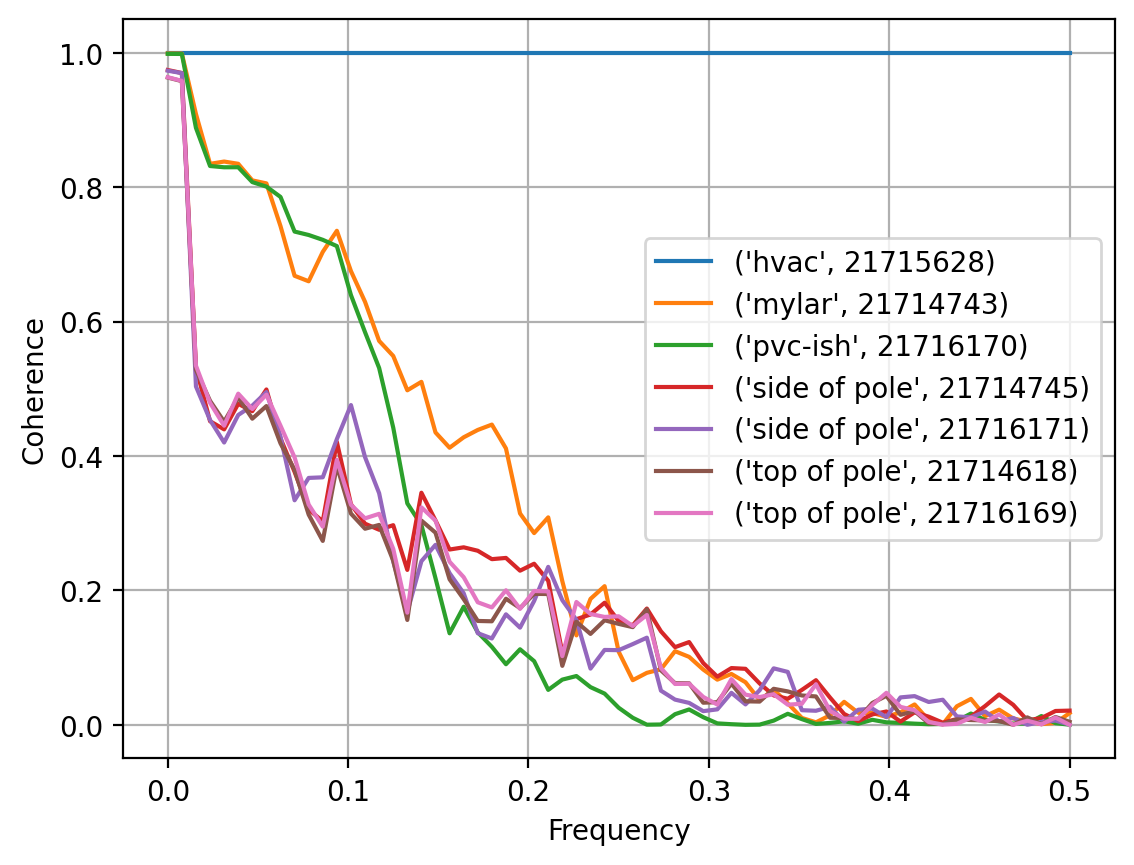

In [17]:
dfp = df.loc[df.sensor_generation == 'new']
fig, ax = plt.subplots(dpi=200)
for exp, group in dfp.groupby(['exp', 'sensor_id']):
    
    hvac = dfp.loc[(dfp.exp == 'hvac')].set_index('datetime')['temp_c']
    group = group.set_index('datetime')['temp_c']
    overlap = pd.merge(hvac, group, left_index=True, right_index=True, how='inner').dropna(how='any')
    hvac = overlap.iloc[:, 0]
    temp = overlap.iloc[:, 1]
    #temp = (temp - temp.mean())/temp.std()
    chunk_size = 128
    ax.cohere(temp, hvac, Fs=1, NFFT=chunk_size, noverlap=chunk_size//2, label=exp)
ax.legend()

Finally, let's generate some summary statistics (which we should have done earlier) to get a sense of the magnitude of differences. Of note: the mean temperature for the unshielded old sensors is actually lower than for the new sensors, even though the median is higher. Worth more investigating!

In [18]:
df.groupby(['sensor_generation', 'exp'])['temp_c'].agg(['mean', 'median', 'std'])

mean  median       std
sensor_generation exp                                      
new               hvac          14.307957  13.810  3.022371
                  mylar         14.181599  13.640  3.149811
                  pvc-ish       14.255449  13.640  3.285439
                  side of pole  16.089407  14.880  4.969893
                  top of pole   16.440739  14.840  5.803351
old               hvac          14.416744  13.846  3.201963
                  side of pole  15.954205  14.996  4.398873
                  top of pole   16.273077  14.996  5.127045

In [19]:
df.groupby(['sensor_generation', 'exp'])['temp_c'].describe()

count       mean       std    min     25%  \
sensor_generation exp                                                         
new               hvac          11786.0  14.307957  3.022371  8.360  12.220   
                  mylar         11786.0  14.181599  3.149811  8.150  12.050   
                  pvc-ish       11786.0  14.255449  3.285439  7.980  12.100   
                  side of pole  23572.0  16.089407  4.969893  7.850  12.610   
                  top of pole   23571.0  16.440739  5.803351  7.080  12.440   
old               hvac          11786.0  14.416744  3.201963  8.382  12.207   
                  side of pole  23572.0  15.954205  4.398873  8.082  12.787   
                  top of pole   11786.0  16.273077  5.127045  7.582  12.497   

                                   50%     75%     max  
sensor_generation exp                                   
new               hvac          13.810  15.910  23.340  
                  mylar         13.640  15.700  24.020  
                  pvc-ish       13.640  16.080  23.850  
                  side of pole  14.880  18.960  37.190  
                  top of pole   14.840  19.260  35.990  
old               hvac          13.846  16.237  24.738  
                  side of pole  14.996  18.901  32.704  
                  top of pole   14.996  19.282  32.394

I don't have time to finish this right now, but here is a brief visual comparison of the light sensor data as well.

In [20]:
dt_start = datetime(2024, 5, 28, 13, 15)
dt_end = datetime(2024, 6, 5, 17, 42)
dt_mask = (df.datetime > dt_start) & (df.datetime < dt_end)
df = df[dt_mask]
df = ds['intensity_lux'].to_pandas().T
df = df.reset_index()
df = df.melt(id_vars='datetime', var_name="sensor_id", value_name="intensity_lux")  # make tidy
df['sensor_id'] = pd.to_numeric(df['sensor_id'])
df = df.merge(id_map, left_on='sensor_id', right_index=True, how='left')

In [21]:
# resample while preserving metadata columns
df_15min = df.groupby([pd.Grouper(freq='15min', key='datetime'), 'exp','sensor_generation', 'sensor_id']).mean().reset_index()
df_15min.head(10)

,datetime,exp,sensor_generation,sensor_id,intensity_lux
0,2024-05-28 11:45:00,hvac,new,21715628,NaN
1,2024-05-28 11:45:00,hvac,old,22008799,NaN
2,2024-05-28 11:45:00,mylar,new,21714743,0.0
3,2024-05-28 11:45:00,pvc-ish,new,21716170,NaN
4,2024-05-28 11:45:00,side of pole,new,21714745,NaN
5,2024-05-28 11:45:00,side of pole,new,21716171,NaN
6,2024-05-28 11:45:00,side of pole,old,22008797,NaN
7,2024-05-28 11:45:00,side of pole,old,22008798,NaN
8,2024-05-28 11:45:00,top of pole,new,21714618,NaN
9,2024-05-28 11:45:00,top of pole,new,21716169,NaN


In [22]:
df.groupby(['sensor_generation', 'exp'])['intensity_lux'].describe()

count          mean           std  min  25%  \
sensor_generation exp                                                           
new               hvac          11865.0      0.546933      0.749917  0.0  0.0   
                  mylar         11870.0      2.699971      4.408531  0.0  0.0   
                  pvc-ish       11856.0    109.123537    168.119467  0.0  0.0   
                  side of pole  23680.0   6344.460771  11455.939604  0.0  0.0   
                  top of pole   23721.0  11058.883374  18764.881809  0.0  0.0   
old               hvac          11811.0      4.169461    114.205821  0.0  0.0   
                  side of pole  23612.0  15751.657162  29576.431550  0.0  0.0   
                  top of pole   11815.0  33919.709742  54222.840570  0.0  0.0   

                                     50%       75%        max  
sensor_generation exp                                          
new               hvac             0.000      0.97       3.89  
                  mylar            0.360      4.12      37.77  
                  pvc-ish         17.945    161.68     911.04  
                  side of pole   938.720   7923.20   86302.72  
                  top of pole   1610.240  14279.68  126525.44  
old               hvac             0.000      0.00    4994.50  
                  side of pole  2325.000  19977.90  187379.00  
                  top of pole   4477.800  46844.80  297602.00

In [23]:
df_15min.groupby(['sensor_generation', 'exp'])['intensity_lux'].describe()

count          mean           std  min  \
sensor_generation exp                                                     
new               hvac           791.0      0.546933      0.725547  0.0   
                  mylar          793.0      2.694296      4.292773  0.0   
                  pvc-ish        792.0    108.904463    163.169567  0.0   
                  side of pole  1580.0   6339.129248  11155.584420  0.0   
                  top of pole   1582.0  11055.871286  18281.009194  0.0   
old               hvac           788.0      4.174484     87.518246  0.0   
                  side of pole  1576.0  15733.013427  28724.075411  0.0   
                  top of pole    789.0  33862.600520  52202.305564  0.0   

                                     25%          50%           75%  \
sensor_generation exp                                                 
new               hvac          0.000000     0.025333      0.999333   
                  mylar         0.000000     0.360667      4.225333   
                  pvc-ish       0.000000    17.689000    159.816000   
                  side of pole  0.000000   926.549333   8177.536000   
                  top of pole   0.004667  1693.120000  14490.026667   
old               hvac          0.000000     0.000000      0.000000   
                  side of pole  0.000000  2336.143333  20483.093333   
                  top of pole   0.000000  4684.473333  48589.953333   

                                          max  
sensor_generation exp                          
new               hvac               3.112000  
                  mylar             31.820000  
                  pvc-ish          733.098667  
                  side of pole   70068.906667  
                  top of pole    95275.690667  
old               hvac            2216.673333  
                  side of pole  164232.193333  
                  top of pole   235142.300000

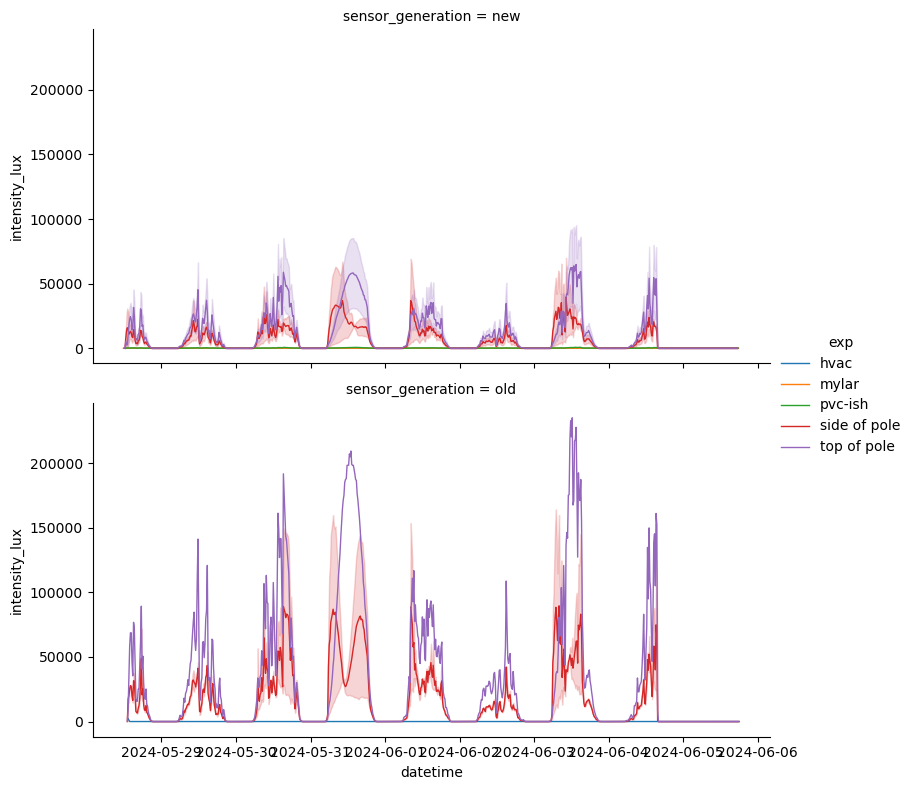

In [24]:
sns.relplot(x='datetime', y='intensity_lux', hue='exp', kind='line', data=df_15min, row='sensor_generation', legend=True, lw=1, height=4, aspect=2)

/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_12242/747500212.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfp = dfp.groupby(['exp','sensor_generation', 'sensor_id'], as_index=False).apply(apply_filter, sos=sos, numeric_cols=['intensity_lux'], include_groups=True).reset_index(drop=True)
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_12242/747500212.py:31: UserWarning: 
The dashes list has fewer values (2) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.relplot(x='datetime', y='intensity_lux', hue='sensor_generation', style='sensor_id', dashes=[(1, 0), (3, 1)],  row='exp', data=dfp, kind='line', legend=True, lw=1, estimator=None, fa

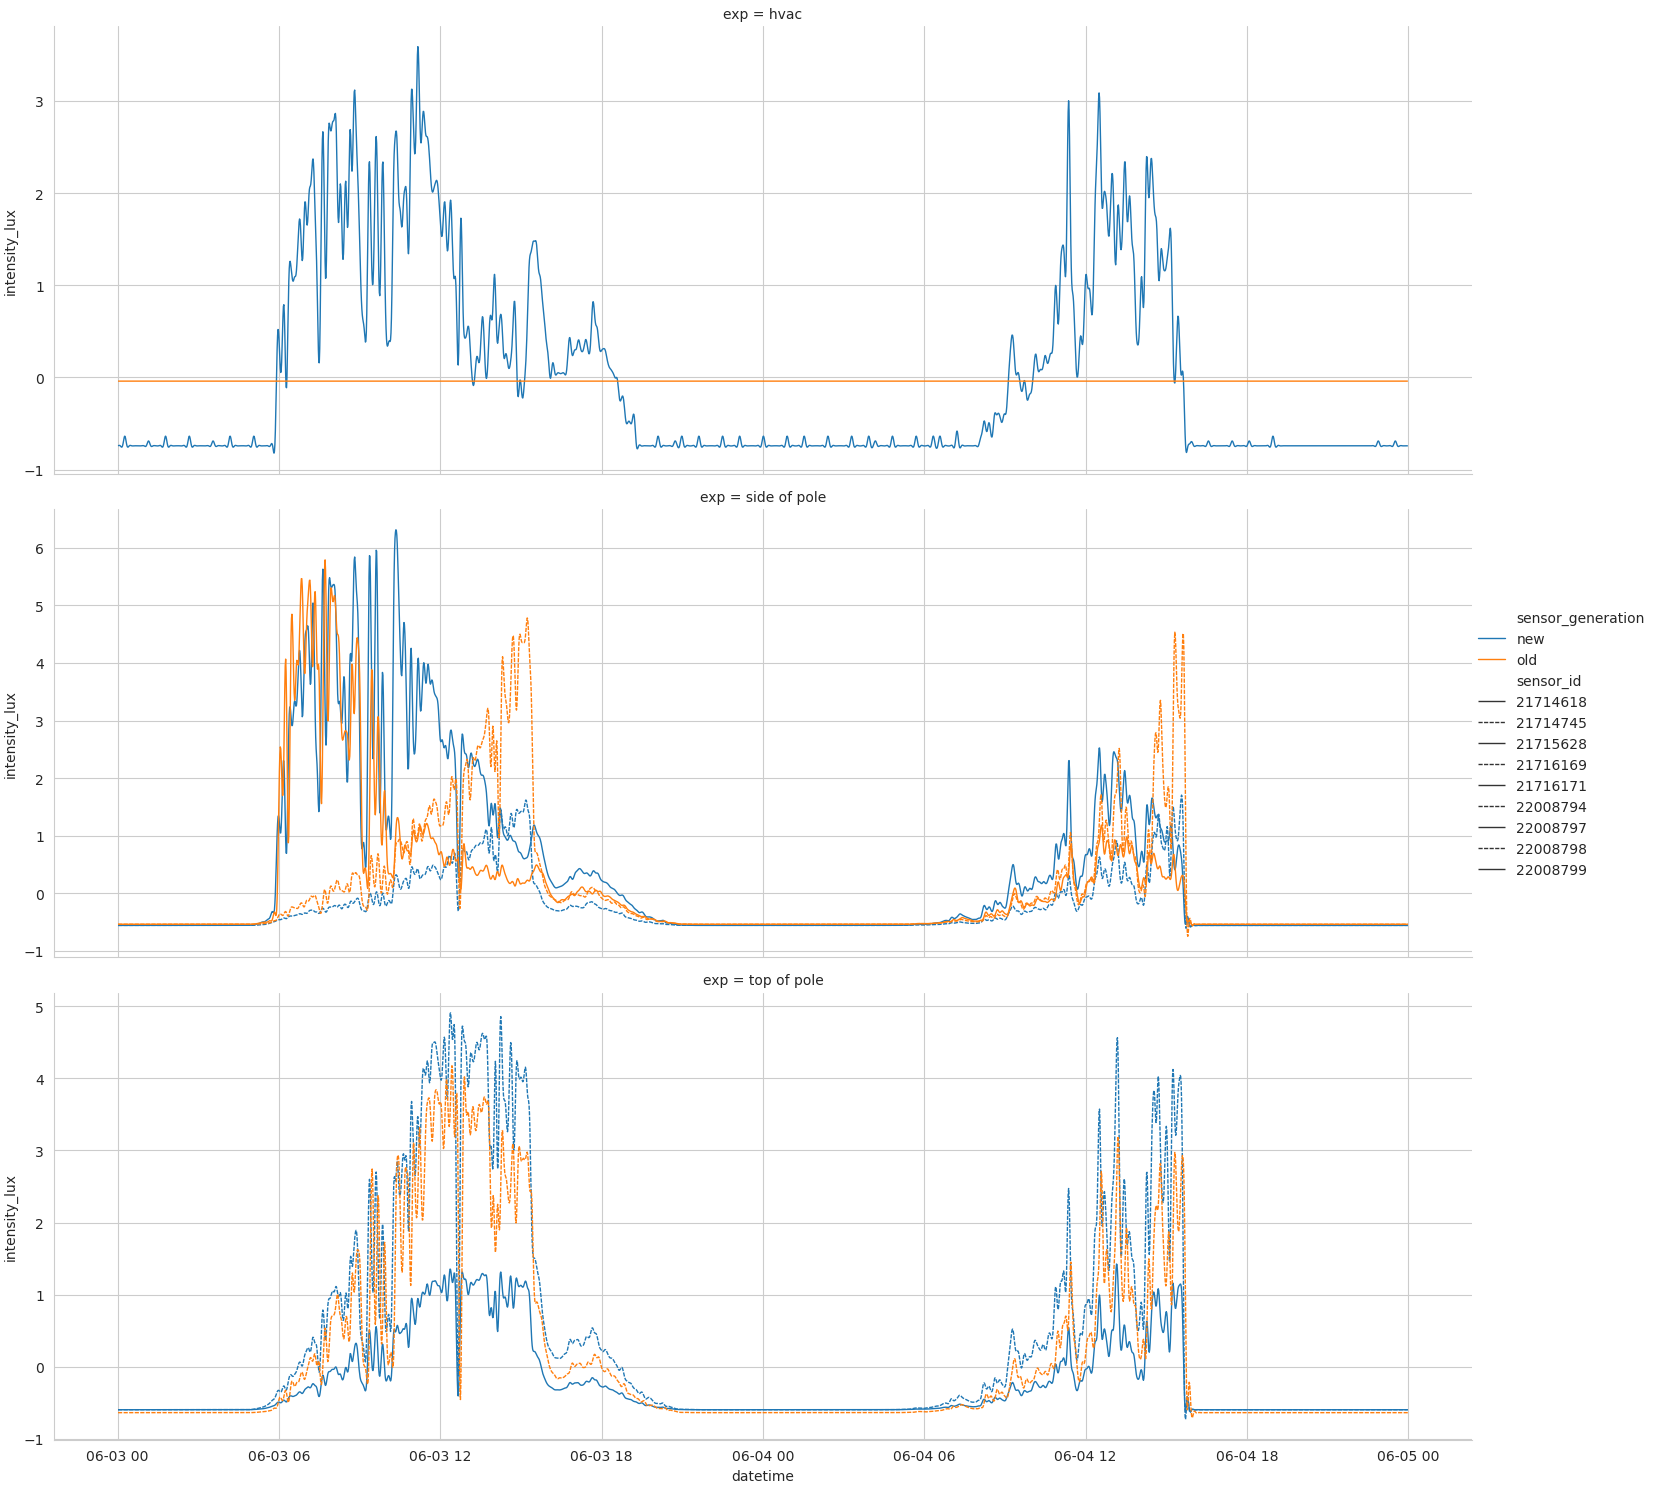

In [25]:
# zoom in on an area

dfp = df.copy()

# minimal amount of smoothing so the plot is readable
fs = 1
cutoff = 1/10
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
sos = sci.signal.butter(4, normal_cutoff, btype='low', analog=False, output='sos')

def apply_filter(group, sos, numeric_cols):
    group = group.dropna()
    group[numeric_cols] = sci.signal.sosfiltfilt(sos, group[numeric_cols].values, axis=0)
    return group

dfp = dfp.groupby(['exp','sensor_generation', 'sensor_id'], as_index=False).apply(apply_filter, sos=sos, numeric_cols=['intensity_lux'], include_groups=True).reset_index(drop=True)

std_dev = dfp.groupby(['exp', 'sensor_generation'])['intensity_lux'].transform('std')
mean = dfp.groupby(['sensor_generation', 'exp'])['intensity_lux'].transform('mean')
dfp['intensity_lux'] = (dfp['intensity_lux'] - mean) / std_dev

dt_start = datetime(2024, 6, 3, 0, 0)
dt_end = datetime(2024, 6, 5, 0, 0)
dt_mask = (dfp.datetime > dt_start) & (dfp.datetime < dt_end)
exp_mask = dfp.loc[dfp.sensor_generation == 'old', 'exp'].unique()
exp_mask = dfp.exp.isin(exp_mask)
dfp = dfp.loc[dt_mask & exp_mask]

with sns.axes_style("whitegrid"):
    sns.relplot(x='datetime', y='intensity_lux', hue='sensor_generation', style='sensor_id', dashes=[(1, 0), (3, 1)],  row='exp', data=dfp, kind='line', legend=True, lw=1, estimator=None, facet_kws=dict(sharey=False), aspect=3)

In [26]:
# Pivot the data
# normalize first so the experiments with replicate sensors can benefit from the additional data
std_dev = df.groupby(['exp'])['intensity_lux'].transform('std')
mean = df.groupby(['sensor_generation', 'exp'])['intensity_lux'].transform('mean')
df_pivot = df.copy()
df_pivot['intensity_lux'] = (df_pivot['intensity_lux'] - mean) / std_dev

# combine replicate sensors
df_pivot = df_pivot.groupby(['sensor_generation', 'exp', 'datetime']).mean().reset_index()

# pivot the new & old sensor values to each have their own column
df_pivot = df_pivot.loc[df_pivot.sensor_generation == 'new'].merge(df_pivot.loc[df_pivot.sensor_generation == "old"], on=['datetime', 'exp'], how='inner', suffixes=["_new", "_old"]).dropna(how='any')

# remove the experiment with covered light sensor
df_pivot = df_pivot.loc[~df_pivot.exp.isin(['hvac'])]

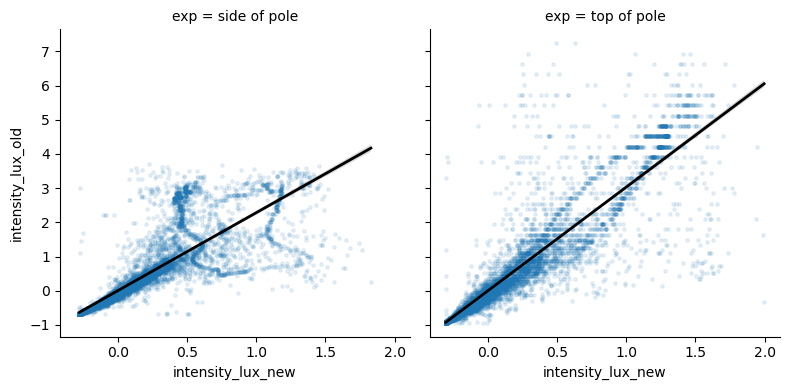

In [31]:
fg = sns.lmplot(df_pivot, x='intensity_lux_new', y='intensity_lux_old', col='exp', height=4, aspect=1, facet_kws={"legend_out":False}, scatter_kws={"alpha":0.1, 's':6}, line_kws={"lw":2, "color":'black'})

Depending on which god(s) you pray to:

In [32]:
df_pivot.groupby('exp')[['intensity_lux_old', 'intensity_lux_new']].corr()

intensity_lux_old  intensity_lux_new
exp                                                                 
side of pole intensity_lux_old           1.000000           0.863244
             intensity_lux_new           0.863244           1.000000
top of pole  intensity_lux_old           1.000000           0.918256
             intensity_lux_new           0.918256           1.000000

In [33]:
df_pivot.groupby('exp')[['intensity_lux_old', 'intensity_lux_new']].corr(method='kendall')

intensity_lux_old  intensity_lux_new
exp                                                                 
side of pole intensity_lux_old           1.000000           0.908883
             intensity_lux_new           0.908883           1.000000
top of pole  intensity_lux_old           1.000000           0.903147
             intensity_lux_new           0.903147           1.000000

In [34]:
df_pivot.groupby('exp')[['intensity_lux_old', 'intensity_lux_new']].corr(method='spearman')

intensity_lux_old  intensity_lux_new
exp                                                                 
side of pole intensity_lux_old           1.000000           0.977550
             intensity_lux_new           0.977550           1.000000
top of pole  intensity_lux_old           1.000000           0.972304
             intensity_lux_new           0.972304           1.000000

In [35]:
for exp, group in df_pivot.groupby('exp'):
    new = group['intensity_lux_new']
    old = group['intensity_lux_old']
    print(exp, sci.stats.linregress(new, old))

side of pole LinregressResult(slope=2.2790719728674507, intercept=0.002563439442511022, rvalue=0.8632441632996866, pvalue=0.0, stderr=0.012274214995340288, intercept_stderr=0.004769521804272969)
top of pole LinregressResult(slope=3.0321296680473817, intercept=-0.0024667156458323316, rvalue=0.9182557827050619, pvalue=0.0, stderr=0.012042797726821815, intercept_stderr=0.005428701434390065)


In future analysis, these values should be compared to the UW radiometer. A key question to answer is whether some combination of up-facing and side-facing light sensors significantly increases correlation with incoming shortwave radiation.